## FACET2e BMAD simple example

You will need to install pytao, BMAD, and openpmd-beamphysics (as well as standard libraries like numpy, matplotlib and pandas)

 conda install -c conda-forge bmad
 conda install -c conda-forge pytao, openpmd-beamphysics

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from plotNMM import plotNMM, slicePlotNMM
from IPython.display import display

#needed for lattice_init
#%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

## Plot single particle twiss

In [3]:
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
#tao.ele_gen_attribs(elements[0])

In [4]:
floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1,1,DL00,Drift,-0.86905,-0.86905,10.69357,0.0,1001.56206,-0.61087,0.0,0.0
26,26,DL01H,Drift,1.03220,0.09012,9.60305,0.0,1003.11948,-0.61087,0.0,0.0
51,51,L0BF#2,Lcavity,5.25643,0.33713,7.18014,0.0,1006.57976,-0.61087,0.0,0.0
76,76,QE10441,Quadrupole,8.50702,0.10800,5.31568,0.0,1009.24248,-0.61087,0.0,0.0
101,101,QE10511#1,Quadrupole,11.14513,0.05400,3.80475,0.0,1011.40031,-0.61087,0.0,0.0
126,126,BPM10581,Monitor,14.40167,0.00000,1.93688,0.0,1014.06791,-0.61087,0.0,0.0
151,151,QB10731#1,Quadrupole,17.73408,0.05340,0.26540,0.0,1016.91774,-0.30543,0.0,0.0


In [5]:

#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])

"""
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)
"""
;

''

# Track particles

## Setup

In [6]:
#tao.cmd('set beam_init n_particle = 10000'); # limit to 10k particles for now

In [7]:
#numMacroParticles = 100000
#tao.cmd(f"set beam_init n_particle = {numMacroParticles}") # limit to 10k particles for now

#Change tracking start/end
#tao.cmd('set beam_init track_end = ENDDL10')
#tao.cmd('set beam_init track_end = PENT')
lastTrackedElement = "PR11335"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

#Can see present track_start and track_end values with `show beam`



#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

In [8]:
def modifyAndSaveInputBeam(
    inputBeamFilePath,
    betaX = None,
    alphaX = None,
    betaY = None,
    alphaY = None,
    numMacroParticles = None,
    timeCenterTF = True):

    #Import
    P = ParticleGroup(inputBeamFilePath)

    #Downsample
    #if numMacroParticles:
    #    P.data.update(resample_particles(P, n=numMacroParticles))
    #PROBLEM! Built-in resampling smushes everything down to a single particle weight. No good for me since I'm using those to keep track of driver/witness
    #Instead, since the weights are ~equal, just pick a random subset then rescale their weights
    initialImportSize = np.size(P.id)
    if numMacroParticles:
        P = P[random.sample(range(initialImportSize), numMacroParticles)]
        P.weight = P.weight * (initialImportSize / numMacroParticles)
    

    #Time center
    if timeCenterTF:
        P.t=P.t-np.mean(P.t) #This is OK because present beam doesn't have different weights; np.unique(P.weight)

    #Apply linear matching
    if (betaX is not None) and (alphaX is not None):
        P.twiss_match(
              plane='x',
              beta = betaX,
              alpha = alphaX,
              inplace=True)

    if (betaY is not None) and (alphaY is not None):
        P.twiss_match(
              plane='y',
              beta = betaY,
              alpha = alphaY,
              inplace=True)

    #Write as the active file
    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

    #Also return the beam object
    return P


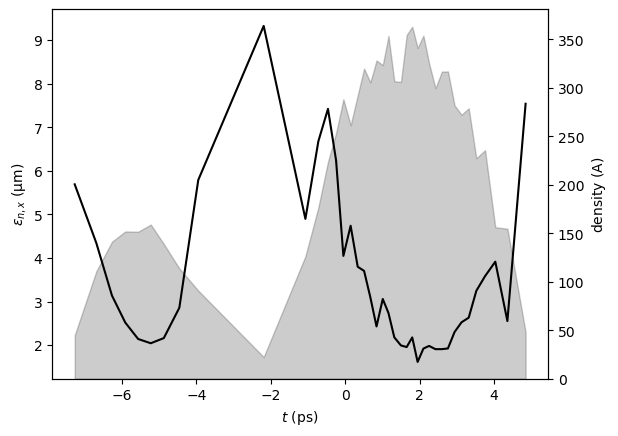

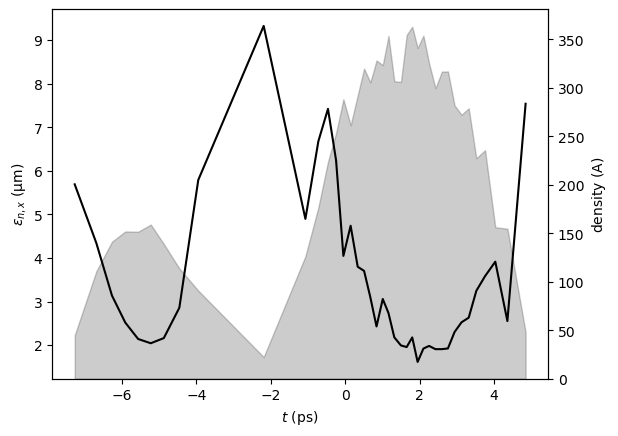

In [9]:
#inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample.h5'
inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5'

#P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/L0AFEND.h5')
#P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch.h5')
#P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample.h5')
#P = ParticleGroup(f'{filePath}/bmad/beams/L0AFEND.h5')

# === For original example beam ===
#print("Before match")
#print(P.twiss(plane='x'))
#print(P.twiss(plane='y'))
#display(plotNMM(P, 'x', 'xp',bins=100))

#numMacroParticles = 1000
#P.data.update(resample_particles(P, n=numMacroParticles))

#P.gamma=P.gamma-np.mean(P.gamma)+tao.lat_list('L0AFEND','ele.e_tot')[0]*1e-6/0.511;
#P.twiss_match(plane='x',
#              beta=35,
#              alpha=-5,
#              inplace=True)
#P.twiss_match(plane='y',beta=tao.lat_list('L0AFEND','ele.b.beta'),alpha=tao.lat_list('L0AFEND','ele.b.alpha'),inplace=True)


#print("After match")
#print(P.twiss(plane='x'))
#print(P.twiss(plane='y'))
#display(plotNMM(P, 'x', 'xp',bins=100))

# === For 2024-02-16_2bunch ===
#if twoBunchTF: 
#P.t=P.t-np.mean(P.t) #This is sloppy because beam weights are not used!!!

#numMacroParticles = 10000
#P.data.update(resample_particles(P, n=numMacroParticles))

#P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

P = modifyAndSaveInputBeam(
    inputBeamFilePath,
    numMacroParticles = 10000
)



tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')# IF you want to change the beam to the new matched beam at the start
#tao.cmd('set beam_init position_file=/Users/cemma/Downloads/facet2-lattice/bmad/beams/L0AFEND.h5')# 
tao.cmd('reinit beam')

#P.slice_plot('norm_emit_x')
display(slicePlotNMM(P, 'norm_emit_x') )

{'alpha_x': -2.988305064278802, 'beta_x': 27.232652316881612, 'gamma_x': 0.3646345953250655, 'emit_x': 6.195393732164196e-08, 'eta_x': 0.00497049196609469, 'etap_x': 0.0005113575129955785, 'norm_emit_x': 7.991129524613306e-06}
{'alpha_y': -2.949217089150349, 'beta_y': 26.86425173190036, 'gamma_y': 0.36099577742642136, 'emit_y': 6.084281733822073e-08, 'eta_y': 0.0025774602292083153, 'etap_y': 0.0003564933317441762, 'norm_emit_y': 7.847811697066556e-06}


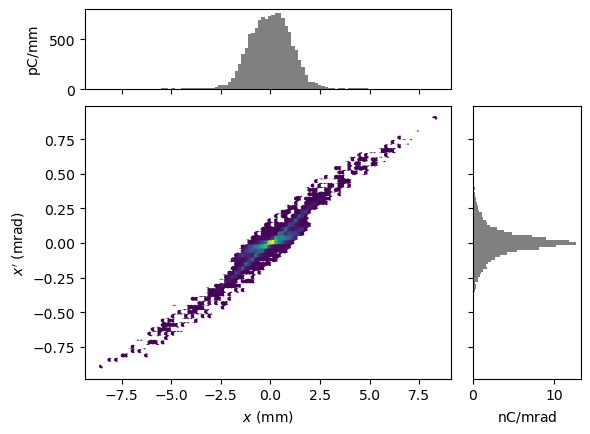

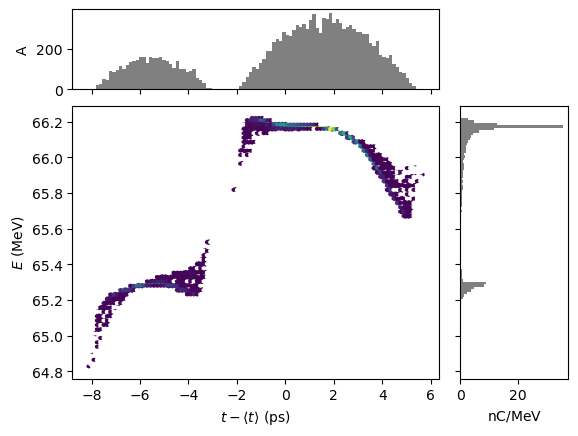

In [10]:
print(P.twiss(plane='x'))
print(P.twiss(plane='y'))

display(plotNMM(P, 'x', 'xp', bins=100))
display(plotNMM(P, 'delta_t', 'energy', bins=100))

# Confirm driver/witness split by weight (not IDs)

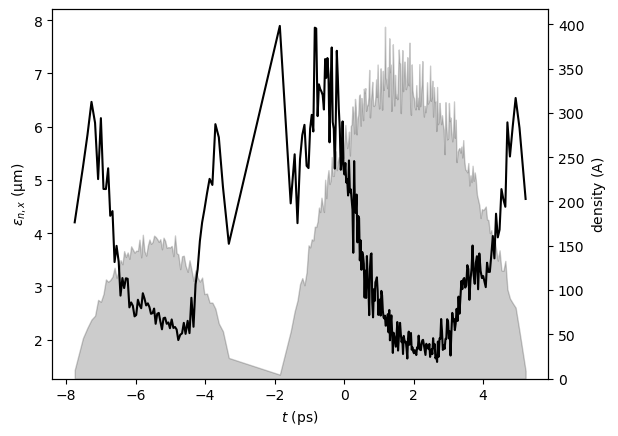

Num driver / witness macroparticles: 76267 / 23733


array([2.09611097e-14, 2.10030739e-14, 2.10030739e-14, ...,
       2.10030739e-14, 2.10030739e-14, 2.10030739e-14])

In [11]:
#This stuff is hardcoded, beware!
#See "2024-03-29_nudgeMacroparticleWeights.ipynb"

P = modifyAndSaveInputBeam(
    inputBeamFilePath,
    timeCenterTF = True);

display(slicePlotNMM(P, 'norm_emit_x', n_slice = 300, slice_key = "t"))

#By eye, pick the dividing line
witnessDriverSplitWeight = np.average(P.weight)
numMacroparticlesAsImported = np.size(P.weight)

driverSubset = P[  P.weight > witnessDriverSplitWeight ]
witnessSubset = P[ P.weight < witnessDriverSplitWeight ]

print(f"Num driver / witness macroparticles: {np.size(driverSubset.weight)} / {np.size(witnessSubset.weight)}")
P.weight

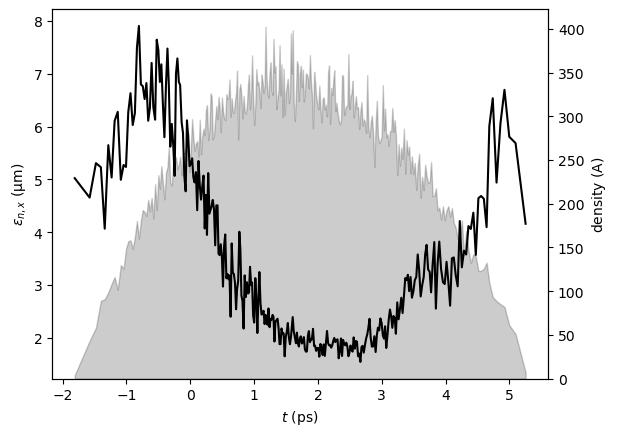

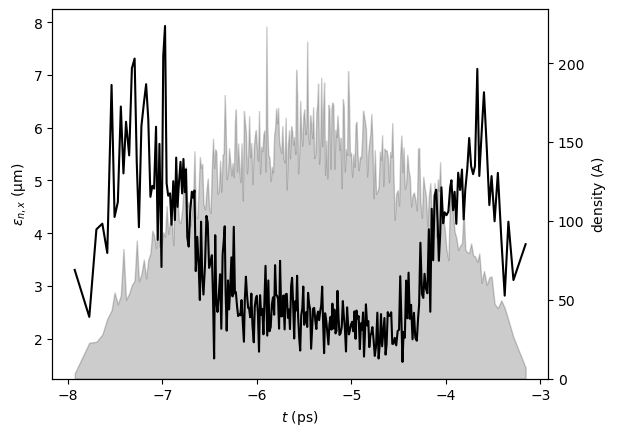

In [12]:
display(slicePlotNMM(driverSubset, 'norm_emit_x', n_slice = 300, slice_key = "t"))
display(slicePlotNMM(witnessSubset, 'norm_emit_x', n_slice = 300, slice_key = "t"))

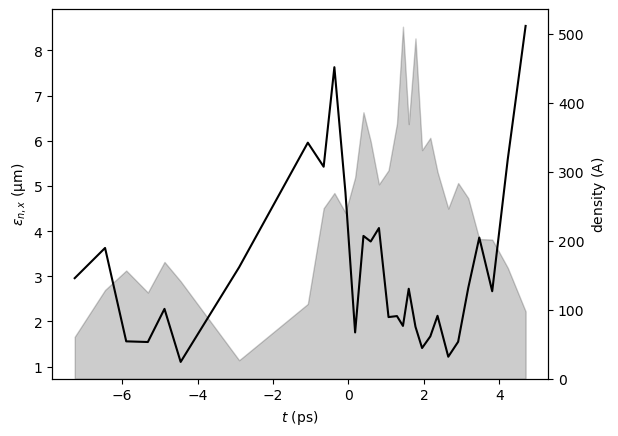

224


array([2.09611097e-12, 2.10030739e-12])

In [13]:
P = modifyAndSaveInputBeam(
    inputBeamFilePath,
    numMacroParticles = 1000,
    timeCenterTF = True);

display(slicePlotNMM(P, 'norm_emit_x', n_slice = 30, slice_key = "t"))



witnessSubset = P[ P.weight * np.size(P.weight) / numMacroparticlesAsImported  < witnessDriverSplitWeight ]

print(f"{np.size(witnessSubset.weight)}")

np.unique(P.weight)

In [14]:
#PROBLEM! Bmad strips the IDs
# P = modifyAndSaveInputBeam(
#     inputBeamFilePath,
#     timeCenterTF = True);
# P.id
# array([1248183., 2994706., 2511880., ..., 2072128., 2829025., 2503797.])

# P = ParticleGroup(data=tao.bunch_data('L0AFEND'))
# P.id
# array([     1,      2,      3, ...,  99998,  99999, 100000])

#I'm going to deal with this by creating a new input file where the witness and driver particles have very, very slightly different weights
#Bmad (presumably...) retains weight data
# tao.bunch_data('L0AFEND')
# {'x': array([-0.00195192,  0.00030864, -0.0004523 , ..., -0.00071584,
#          0.00193254,  0.00020216]),
#  'px': array([-4420.96969495,  -685.02317667,   133.48213397, ...,
#          -342.74119023,  -922.60208893,   108.49622748]),
#  'y': array([ 8.59443329e-04, -2.54455833e-04,  1.89575995e-04, ...,
#          5.65670775e-04, -8.43240229e-05,  5.80456205e-04]),
#  'py': array([7467.50791431,  -33.53628711,  566.19673442, ..., 1441.97856318,
#         -143.50800545, 1806.11092054]),
#  't': array([-5.17371712e-12,  1.69013303e-12,  2.60064835e-13, ...,
#         -1.00286780e-12,  1.29688271e-12,  2.12125643e-13]),
#  'pz': array([65293100.65247   , 66168140.85241183, 66168857.13704683, ...,
#         66197878.14223742, 66172382.71861624, 66170620.39594007]),
#  'status': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
#  'weight': array([2.09820918e-14, 2.09820918e-14, 2.09820918e-14, ...,
#         2.09820918e-14, 2.09820918e-14, 2.09820918e-14]),
#  'z': array([0, 0, 0, ..., 0, 0, 0]),
#  'species': 'electron'}
;

''

# Test

Both bunches


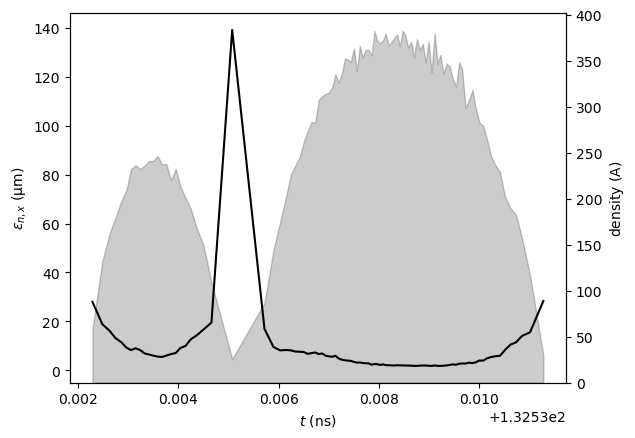

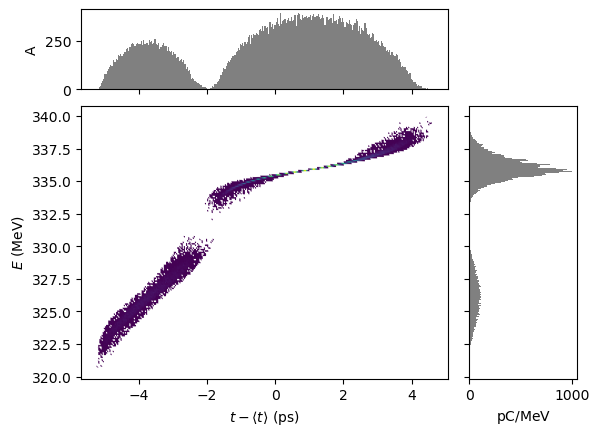

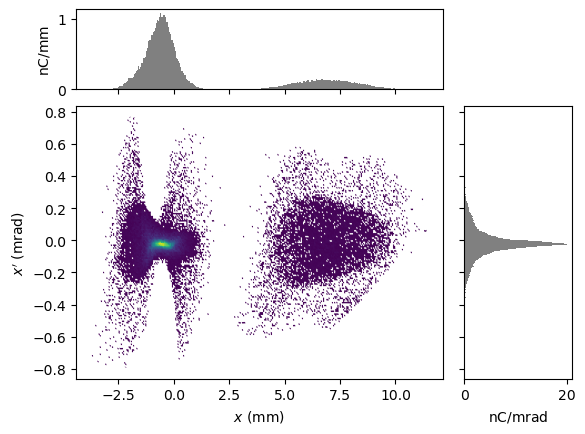

Driver only


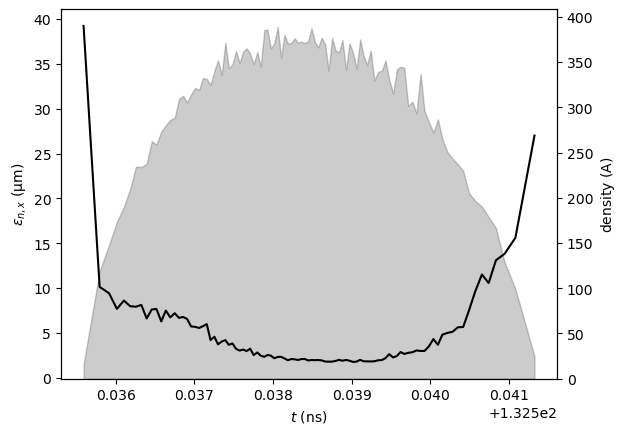

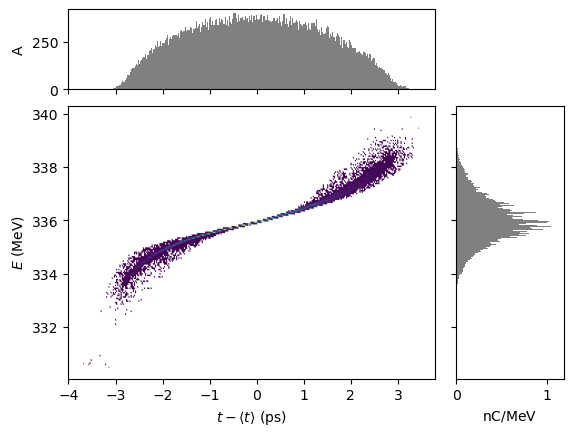

Witness only


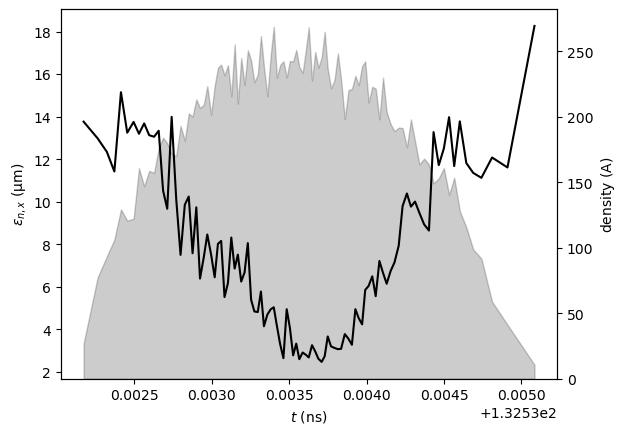

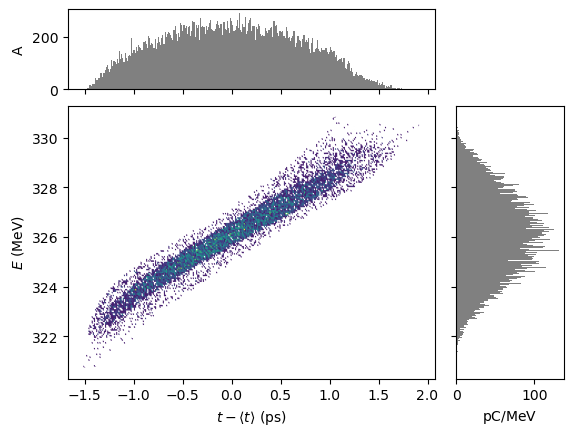

In [15]:
P = modifyAndSaveInputBeam(
    inputBeamFilePath,
    #numMacroParticles = 10000
)



tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')# IF you want to change the beam to the new matched beam at the start
#tao.cmd('set beam_init position_file=/Users/cemma/Downloads/facet2-lattice/bmad/beams/L0AFEND.h5')# 
tao.cmd('reinit beam')




tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

plt.close('all')
P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

#Drop lost/nonsense particles
selectParticles = P[P.pz > 100e6]

print("Both bunches")
display(slicePlotNMM(selectParticles, 'norm_emit_x',n_slice=100))
display(plotNMM(selectParticles, 'delta_t', 'energy', bins=300))
display(plotNMM(selectParticles, "x","xp", bins=300))


#Now look at bunches independently
driverSubset = selectParticles[ selectParticles.weight > witnessDriverSplitWeight ]
witnessSubset = selectParticles[ selectParticles.weight < witnessDriverSplitWeight ]

print("Driver only")
display(slicePlotNMM(driverSubset, 'norm_emit_x',n_slice=100))
display(plotNMM(driverSubset, 'delta_t', 'energy', bins=300))

print("Witness only")
display(slicePlotNMM(witnessSubset, 'norm_emit_x',n_slice=100))
display(plotNMM(witnessSubset, 'delta_t', 'energy', bins=300))

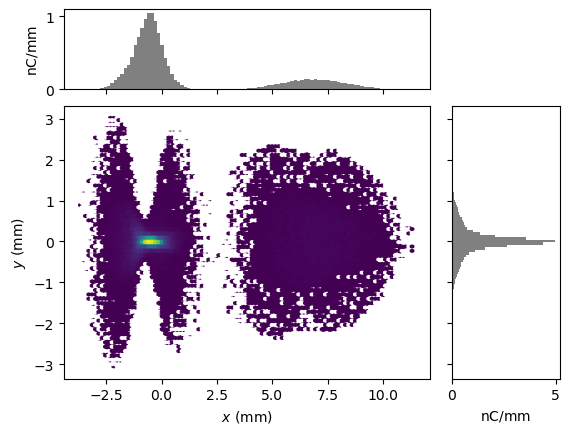

In [17]:
display(plotNMM(selectParticles, 'x', 'y', bins=100))